In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss, roc_auc_score

from scipy.sparse import hstack

import matplotlib.pyplot as plt

In [2]:
def read_data() -> pd.DataFrame: 
    data = pd.read_csv('../data/data.csv', parse_dates=['date_time'])

    # will be used in next HWs
    cols_for_other_hws = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1']

    # has only one value for all rows
    cols_constant = ['impressions']

    data.drop(cols_for_other_hws, axis=1, inplace=True)
    data.drop(cols_constant, axis=1, inplace=True)
    data.dropna(inplace=True)

    return data

data = read_data()
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1
1,2021-09-26 22:54:49,1,1,0,0,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1
3,2021-09-27 00:04:30,3,3,0,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1


# Analysis

categorical features:
Unique values for column 'zone_id': [   0    1    2 ... 3441 3442 3443]
Unique values for column 'banner_id': [   0    1    2 ... 1630 1631 1632]
Unique values for column 'os_id': [ 0  1  2  3  4  5  6  7  8  9 10]
Unique values for column 'country_id': [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

numerical features:
campaign_clicks min: 0
campaign_clicks max: 829
campaign_clicks mean: 0.6238539625137282


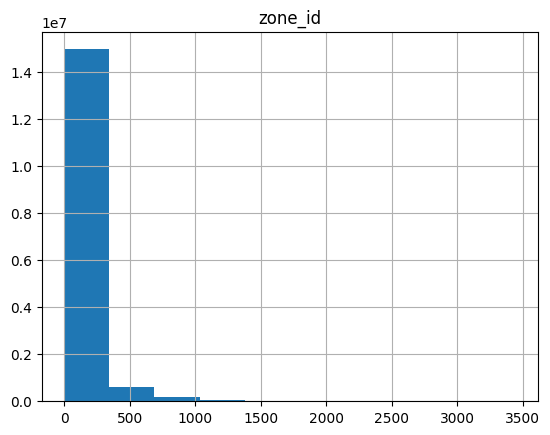

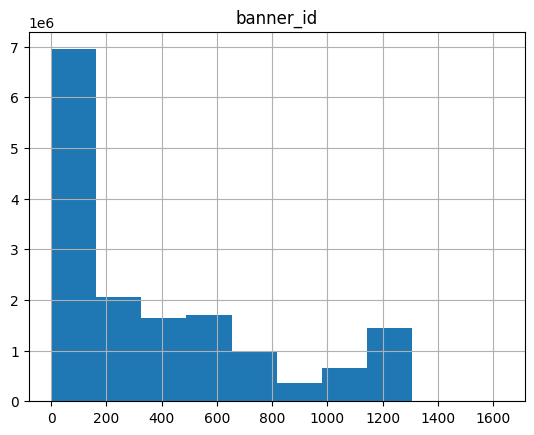

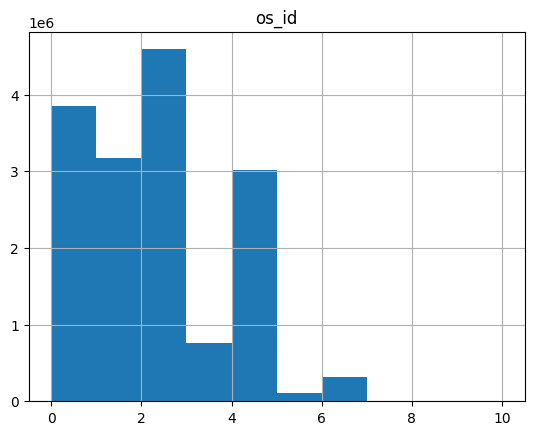

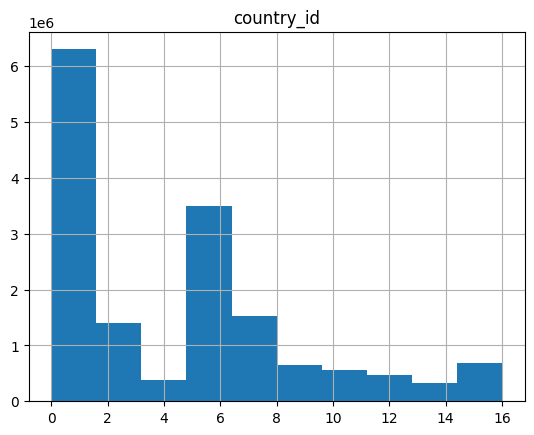

In [3]:
def analysis(data: pd.DataFrame):
    categorical_features = ['zone_id', 'banner_id', 'os_id', 'country_id']
    numerical_features = ['campaign_clicks']

    print('categorical features:')
    for column in categorical_features:
        unique_values = data[column].unique()
        print(f"Unique values for column '{column}': {unique_values}")

    print('\nnumerical features:')
    for column in numerical_features:
        print(f'{column} min: {data[column].min()}')
        print(f'{column} max: {data[column].max()}')
        print(f'{column} mean: {data[column].mean()}')        

    for col in categorical_features:
        data.hist(col)               
        plt.show()

analysis(data)
    

# Feature Engineering

In [29]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # train / test split    
    last_day = data.date_time.max().date()    
    train_data = data[data.date_time.dt.date != last_day]
    y_train = train_data.clicks.to_numpy()
    test_data = data[data.date_time.dt.date == last_day]        
    y_test = test_data.clicks.to_numpy()

    # categorical features
    categorical_features = ['zone_id', 'banner_id', 'os_id', 'country_id']
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    train_sparse = encoder.fit_transform(train_data[categorical_features])
    test_sparse = encoder.transform(test_data[categorical_features])

    # numerical features
    numerical_features = ['campaign_clicks']   
    scaler = StandardScaler()
    train_dense = scaler.fit_transform(train_data[numerical_features])
    test_dense = scaler.transform(test_data[numerical_features])

    # concat sparse + dense
    X_train = hstack([train_sparse, train_dense])
    X_test = hstack([test_sparse, test_dense])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = feature_engineering(data)

print(f'features: {X_train.shape[1]}')
print(f'train size: {len(y_train)}')
print(f'test size: {len(y_test)}')

features: 4945
train size: 13692494
test size: 2128978


# Cross Validation

In [30]:
def create_model(C: float) -> LogisticRegression:
    model = LogisticRegression(penalty='l2', solver='liblinear', C=C, random_state=1234)    
    return model

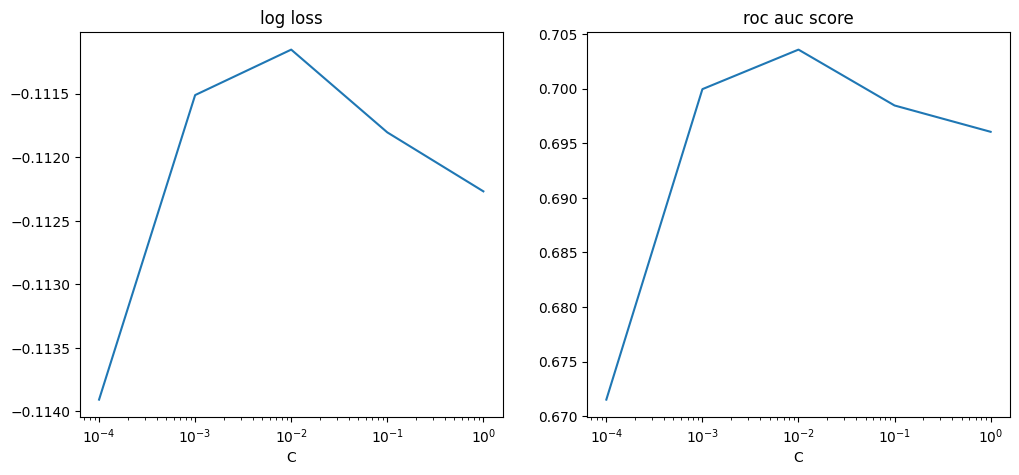

In [31]:
def cv(X, y):
    log_loss_score = []
    roc_auc_score = []
    grid = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for C in grid:
        score = cross_validate(estimator=create_model(C),
                               X=X, y=y,
                               scoring=['neg_log_loss', 'roc_auc'],
                               cv=3)
        log_loss_score.append(score['test_neg_log_loss'].mean())
        roc_auc_score.append(score['test_roc_auc'].mean())

    return grid, log_loss_score, roc_auc_score

grid, log_loss_score, roc_auc_score = cv(X_train, y_train)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title('log loss')
plt.plot(grid, log_loss_score, label='log loss')
plt.xlabel('C')
plt.xscale('log')
plt.subplot(122)
plt.title('roc auc score')
plt.plot(grid, roc_auc_score, label='roc auc score')
plt.xlabel('C')
plt.xscale('log')
plt.show()

# Perfomance

In [35]:
y_pred = np.full(len(y_test), y_train.mean())
print('baseline performance:')
print(f'log loss: {log_loss(y_test, y_pred)}')
print(f'roc_auc_score: {roc_auc_score(y_test, y_pred)}')

baseline performance:
log loss: 0.15486198009919555
roc_auc_score: 0.5


In [37]:
model = create_model(C=0.01).fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
print('model performance:')
print(f'log loss: {log_loss(y_test, y_pred)}')
print(f'roc_auc_score: {roc_auc_score(y_test, y_pred)}')

model performance:
log loss: 0.13359587610199455
roc_auc_score: 0.779136370914316
